In [0]:
# from google.colab import drive
# import pandas as pd
# drive.mount('/content/gdrive') # 此處需要登入google帳號

In [0]:
import numpy
import os
import cv2
import matplotlib.pyplot as plt
import pickle
# Visualizations will be shown in the notebook.
%matplotlib inline


Read pickle file

In [0]:
test_file ='/content/testing_img.pkl'
test_label_file = '/content/testing_label.pkl'
with open(test_file, mode='rb') as f:
    X_test = pickle.load(f)

with open(test_label_file, mode='rb') as f:
    tlabel = pickle.load(f)
y_test = tlabel['labels']

In [0]:
training_file ='/content/training_img.pkl'
training_label_file = '/content/training_label.pkl'
with open(training_file, mode='rb') as f:
    X_train = pickle.load(f)

with open(training_label_file, mode='rb') as f:
    label = pickle.load(f)
y_train = label['labels']


In [0]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples
n_train = np.shape(X_train)[0]

# TODO: What's the shape of an traffic sign image?
image_shape =  np.shape(X_train[0])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 4253
Image data shape = (32, 32, 3)
Number of classes = 40


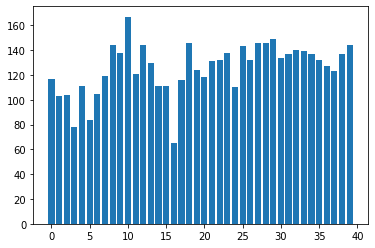

[ 0  0  0 ... 39 39 39]


In [0]:
#plot

hist = np.arange(n_classes)
for i in range(len(y_train)):
    hist[y_train[i]] += 1
plt.bar(range(n_classes), hist)
plt.savefig('bar_chart.png')
plt.show()
squares =np.array([[1,4,9,16,25]]) 
print(y_train)

In [0]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

import cv2

def preProcessData(img_data):
    #normalize    
    img_data = np.average(img_data,axis=3)
    img_data = np.subtract(img_data,128.0)
    img_data = np.divide(img_data,128.0)
    img_data = np.reshape(img_data,(img_data.shape[0],img_data.shape[1],img_data.shape[2],1))
    print(img_data.shape)
    return img_data

X_train_normalize = preProcessData(X_train)
X_test_normalize = preProcessData(X_test)
X_train_data = (np.array(X_train))
print(X_train_data.shape)

(4253, 32, 32, 1)
(1063, 32, 32, 1)
(4253, 32, 32, 3)


In [0]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

EPOCHS = 150
BATCH_SIZE = 128
rate = 0.001


def LeNet(x):
    mu = 0
    sigma = 0.1
    
    #Layer 1: Conv. In:32x32x3. Out:28x28x6.
    #window
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6) , mean = mu, stddev = sigma))
    #bias
    conv1_b = tf.Variable(tf.zeros(6))
    #conv2D
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    #Activation
    conv1 = tf.nn.relu(conv1)
    
    #Pooling In:28x28x6. Out:14x14x6.
    #ksize = [1, h, w, 1] stride = [1, stride, stirde, 1]
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding = 'VALID')
    
    #Layer 2: Conv. In:14x14x6. Out:10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16) , mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation
    conv2 = tf.nn.relu(conv2)
    
    #Pooling In:10x10x16. Out:5x5x16.
    #ksize = [1, h, w, 1] stride = [1, stride, stirde, 1]
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding = 'VALID')
    
    # Flatten. In:5x5x16. Out:400.
    fc0   = tf.compat.v1.layers.flatten(conv2)
    
    #Layer 3: Fully Connected. In:400. Out:120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    #fc0*fc1_W+fc1_b
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation
    fc1 = tf.nn.relu(fc1)
    dr1 = tf.nn.dropout(fc1, keep_prob)
    
    #Layer 4: Fully Connected. In:120. Out:84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2  = tf.matmul(dr1, fc2_W) + fc2_b
    
    #Activation
    fc2 = tf.nn.relu(fc2)
    dr2 = tf.nn.dropout(fc2, keep_prob)
    
    #Layer 5: Fully Connected. In:84. Out:43.    
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 40), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(40))
    fc3  = tf.matmul(dr2, fc3_W) + fc3_b
    
    return fc3

In [0]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 40) # out: [y x 43]


In [0]:
#parma

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits = logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [0]:
def evaluate(X_data, y_data, p):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y , keep_prob : p})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [0]:
from sklearn.utils import shuffle
loss_array = []
validation_accuracy_array = []
train_accuracy_array = []
save_file = 'lenet'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalize)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_normalize, y_train = shuffle(X_train_normalize, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalize[offset:end], y_train[offset:end]
            _,loss =sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y,keep_prob : 0.5})
        loss_array.append(loss)
        train_accuracy = evaluate(X_train_normalize,y_train, 0.7)
        #validation_accuracy = evaluate(X_valid_normalize, y_valid, 0.7) 
        #validation_accuracy_array.append(validation_accuracy)
        train_accuracy_array.append(train_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("  Training Accuracy = {:.3f}".format(train_accuracy))
        print()     
    saver.save(sess, save_file)
    print("Model saved")

Training...

EPOCH 1 ...
  Training Accuracy = 0.041

EPOCH 2 ...
  Training Accuracy = 0.052

EPOCH 3 ...
  Training Accuracy = 0.091

EPOCH 4 ...
  Training Accuracy = 0.126

EPOCH 5 ...
  Training Accuracy = 0.183

EPOCH 6 ...
  Training Accuracy = 0.230

EPOCH 7 ...
  Training Accuracy = 0.276

EPOCH 8 ...
  Training Accuracy = 0.301

EPOCH 9 ...
  Training Accuracy = 0.323

EPOCH 10 ...
  Training Accuracy = 0.367

EPOCH 11 ...
  Training Accuracy = 0.380

EPOCH 12 ...
  Training Accuracy = 0.409

EPOCH 13 ...
  Training Accuracy = 0.380

EPOCH 14 ...
  Training Accuracy = 0.443

EPOCH 15 ...
  Training Accuracy = 0.462

EPOCH 16 ...
  Training Accuracy = 0.474

EPOCH 17 ...
  Training Accuracy = 0.485

EPOCH 18 ...
  Training Accuracy = 0.503

EPOCH 19 ...
  Training Accuracy = 0.522

EPOCH 20 ...
  Training Accuracy = 0.526

EPOCH 21 ...
  Training Accuracy = 0.546

EPOCH 22 ...
  Training Accuracy = 0.548

EPOCH 23 ...
  Training Accuracy = 0.583

EPOCH 24 ...
  Training Accura

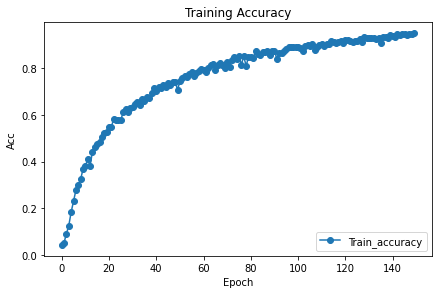

In [0]:
plt.title('Training Accuracy')
plt.plot(train_accuracy_array,'-o')
plt.tight_layout()
plt.savefig('Training_Accuracy.png')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train_accuracy'], loc='lower right')

Text(0.5, 6.799999999999997, 'Epoch')

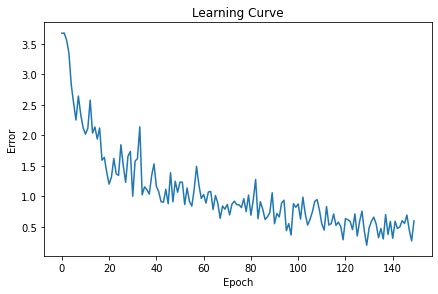

In [0]:
plt.title('Learning Curve')
plt.plot(loss_array)
plt.tight_layout()
plt.savefig('learning_curve.png')
plt.ylabel('Error')
plt.xlabel('Epoch')

In [0]:
with tf.Session() as sess:
    saver.restore(sess, save_file)
    test_accuracy = evaluate(X_test_normalize, y_test, 1.0)
    print("Test Acc = {:.3f} ".format(test_accuracy))

INFO:tensorflow:Restoring parameters from lenet
Test Acc = 0.902 


INFO:tensorflow:Restoring parameters from lenet


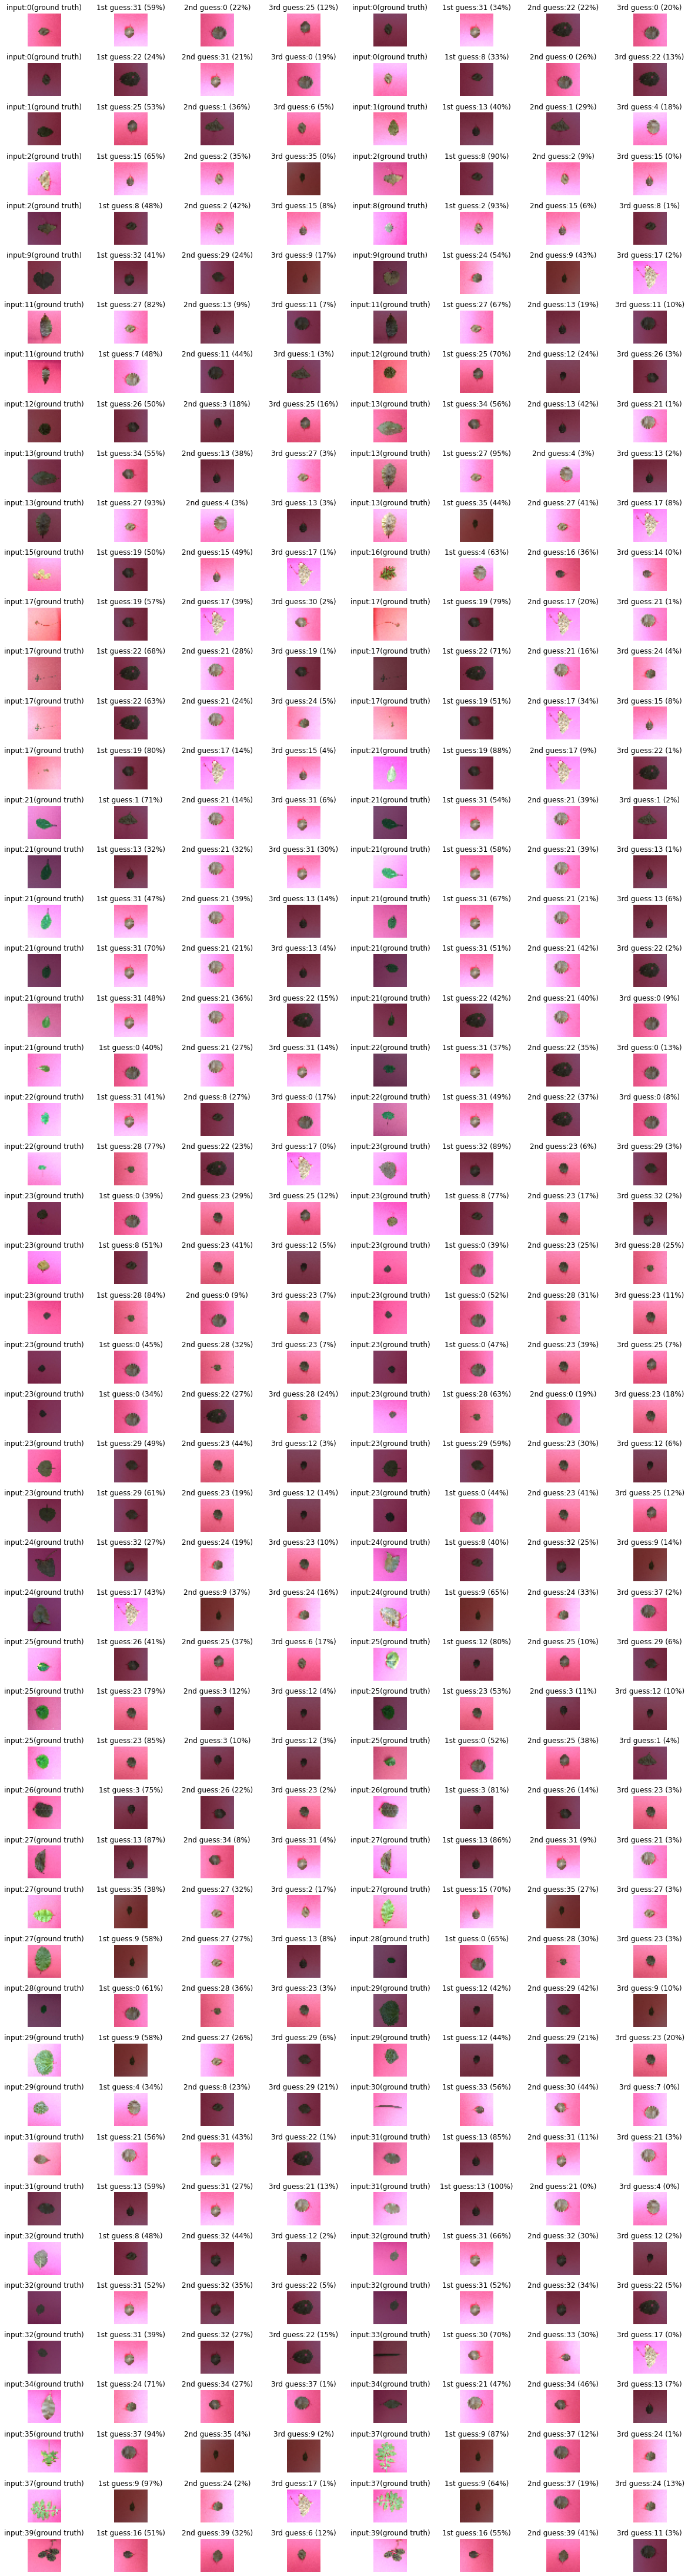

In [0]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
import csv

softmax = tf.nn.softmax(logits)
top_3 = tf.nn.top_k(softmax, k=3)
n = 4
with tf.Session() as sess:
    saver.restore(sess, save_file)
    top_3_result = sess.run(top_3, feed_dict={x: X_test_normalize, keep_prob: 1.0})
    #print(top_3_result)
    #print(top_3_result.indices.shape)

    fig, axs = plt.subplots(52, 2*n, figsize=(20,80))
    fig.subplots_adjust(hspace = .5, wspace= .7)
    axs = axs.ravel()
    count = 0
    for i, image in enumerate(X_test):
      #the figure just show the wrong prediction image
        if top_3_result[1][i][0] == y_test[i]:
          continue
        axs[n*count].axis('off')
        axs[n*count].imshow(image.squeeze(), cmap='gray')
        axs[n*count].set_title('input:%d(ground truth)'%y_test[i])

        top1 = top_3_result[1][i][0]
        idx1 = np.argwhere(list(map(int, y_train)) == top1)[0]
        axs[n*count+1].axis('off')
        axs[n*count+1].imshow(X_train_data[idx1].squeeze(), cmap='gray')
        axs[n*count+1].set_title('1st guess:{} ({:.0f}%)'.format(top1, 100*top_3_result[0][i][0]))
        
        top2 = top_3_result[1][i][1]
        idx2 = np.argwhere(list(map(int, y_train)) == top2)[0]        
        axs[n*count+2].axis('off')
        axs[n*count+2].imshow(X_train_data[idx2].squeeze(), cmap='gray')
        axs[n*count+2].set_title('2nd guess:{} ({:.0f}%)'.format(top2, 100*top_3_result[0][i][1]))
        
        top3 = top_3_result[1][i][2]
        idx3 = np.argwhere(list(map(int, y_train)) == top3)[0]        
        axs[n*count+3].axis('off')
        axs[n*count+3].imshow(X_train_data[idx3].squeeze(), cmap='gray')
        axs[n*count+3].set_title('3rd guess:{} ({:.0f}%)'.format(top3, 100*top_3_result[0][i][2]))

        count = count + 1
    with open('output.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(['input','1st guess','2nd guess','3rd guess'])
      for i,indice in enumerate(top_3_result.indices):
        writer.writerow(np.concatenate([np.array([y_test[i]]),indice]))